In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%cd C:\Users\user\Desktop\KUL - Mstat\Modern Data Analytics\proj 

C:\Users\user\Desktop\KUL - Mstat\Modern Data Analytics\proj


**<font color='green'>Using reference distributions are recommended. Research papers that use references:</font>**

Link 1. https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjBx7mi98DwAhWRGBQKHcq6C04QFjAQegQICRAD&url=https%3A%2F%2Fwww.mdpi.com%2F2073-4441%2F12%2F4%2F962%2Fpdf&usg=AOvVaw3POLb259dUlg-2Ed15Nw3y

Link 2. https://www.cawcr.gov.au/technical-reports/CTR_060.pdf

**<font color='green'>Monthly mortality data from Stabel</font>**

Link: https://statbel.fgov.be/en/about-statbel/what-we-do/visualisations/mortality

In [2]:
mortality = pd.read_excel('cause of death.xlsx') # Monthly mortality data with causes from Stabel
reference_dist = pd.read_csv('reference_dist_1983_to_2008.csv') # 1983 Jan 01 - 2008 Dec 31 as references

In [3]:
# First 16 rows are text / sentences
ROW_SKIP = 16
climate_brussels = pd.read_csv('Daily_20090101_20201231_brussels.csv', skiprows = ROW_SKIP)
climate_dinant = pd.read_csv('Daily_20090101_20201231_dinant.csv',  skiprows = ROW_SKIP)
climate_antwerp = pd.read_csv('Daily_20090101_20201231_antwerp.csv', skiprows = ROW_SKIP)

In [4]:
# Check column names
mortality.columns

Index(['REGION', 'MONTH', 'YEAR', 'AGE-GROUP', 'SEX', 'COD', 'COUNT'], dtype='object')

In [5]:
# Data cleaning 
class cleaner_climate():
    def __init__(self, brussels, antwerp, dinant, reference):
        # Rename columns to make them aligned with 'mortality' set
        date_dict = {'YEAR': 'YEAR', 'MO': 'MONTH', 'DY': 'DAY'}
        self.brussels = brussels.rename(columns = date_dict)
        self.antwerp = antwerp.rename(columns = date_dict)
        self.dinant = dinant.rename(columns = date_dict)
        self.ref = reference
        # Create a region column to make them aligned with 'mortality' dataset
        region_name = 'REGION'
        self.brussels[region_name] = 4000
        self.antwerp[region_name] = 2000
        self.dinant[region_name] = 3000
    
    def concatenate(self):
        # Concatenate brussels, antwerp, dinant together *vertically*
        df_results = pd.DataFrame()
        return df_results.append([self.brussels, self.antwerp, self.dinant])
    
    def count_consecutive(self, x):
        # String trick
        x_str = ''.join(map(lambda x: str(int(x)), x.to_list())) # For each groupby, join the list into string e.g. 00001111010011
        x_str = x_str.replace('0', ' ').split(' ') # replace 0 with empty string and split e.g. ['', '1111', '', 1, '', 11]
        x_str = list(filter(lambda x: len(x) >= 2, x_str)) # Filter to a list, count length > 2 (consecutive heatwave days) e.g. ['1111', '11']
        return len(''.join(x_str)) # Join all substrings together and count the total number of consecutive heatwave days within a month e.g. '111111'
        
    def monthly_stat(self):
        df_results = pd.DataFrame()
        group_list = ['REGION', 'YEAR', 'MONTH']
        df_groupby = self.concatenate().groupby(group_list)
        # Do some features transformation here, add extra columns if needed
        df_results['TEMP_MEAN'] = df_groupby['T2M_MAX'].mean() # Mean of daily temperature
        df_results['TEMP_VAR'] = df_groupby['T2M_MAX'].std() # Standard deviation of daily temperature
        df_results['TEMP_RNG'] = df_groupby['T2M_RANGE'].max() # Maximum daily temperature range
        df_results['WS50M_MEAN'] = df_groupby['WS50M'].mean() # Average daily wind speed
        df_results['PRECTOT_MEAN'] = df_groupby['PRECTOT'].mean() # Average daily precipitation
        df_results['RH2M_MEAN'] = df_groupby['RH2M'].mean() # Average relative humidity
        return df_results
    
    def featurize(self):
        on_key = ['REGION', 'YEAR', 'MONTH']
        on_key2 = ['REGION', 'MONTH']
        df_monthly_stat = self.monthly_stat().reset_index().merge(reference_dist, how = 'left', on = on_key2)
        df_results = self.concatenate().merge(df_monthly_stat, how = 'left', on = on_key)
        # ABOVE_LIMIT: If daily max temperature > 90th percentile from the reference, 1. Else 0
        df_results['ABOVE_LIMIT'] = (df_results['T2M_MAX'] > df_results['TEMP_90th']).astype(np.float64)
        df_monthly_stat['HEAT_DAYS'] = df_results.groupby(on_key)['ABOVE_LIMIT'].agg(self.count_consecutive).values
        
        drop_list = ['TEMP_90th']
        return df_monthly_stat.drop(drop_list, axis = 1)

In [6]:
# Data cleaning
Cleaner = cleaner_climate(climate_brussels, climate_antwerp, climate_dinant, reference_dist)
climate = Cleaner.featurize()

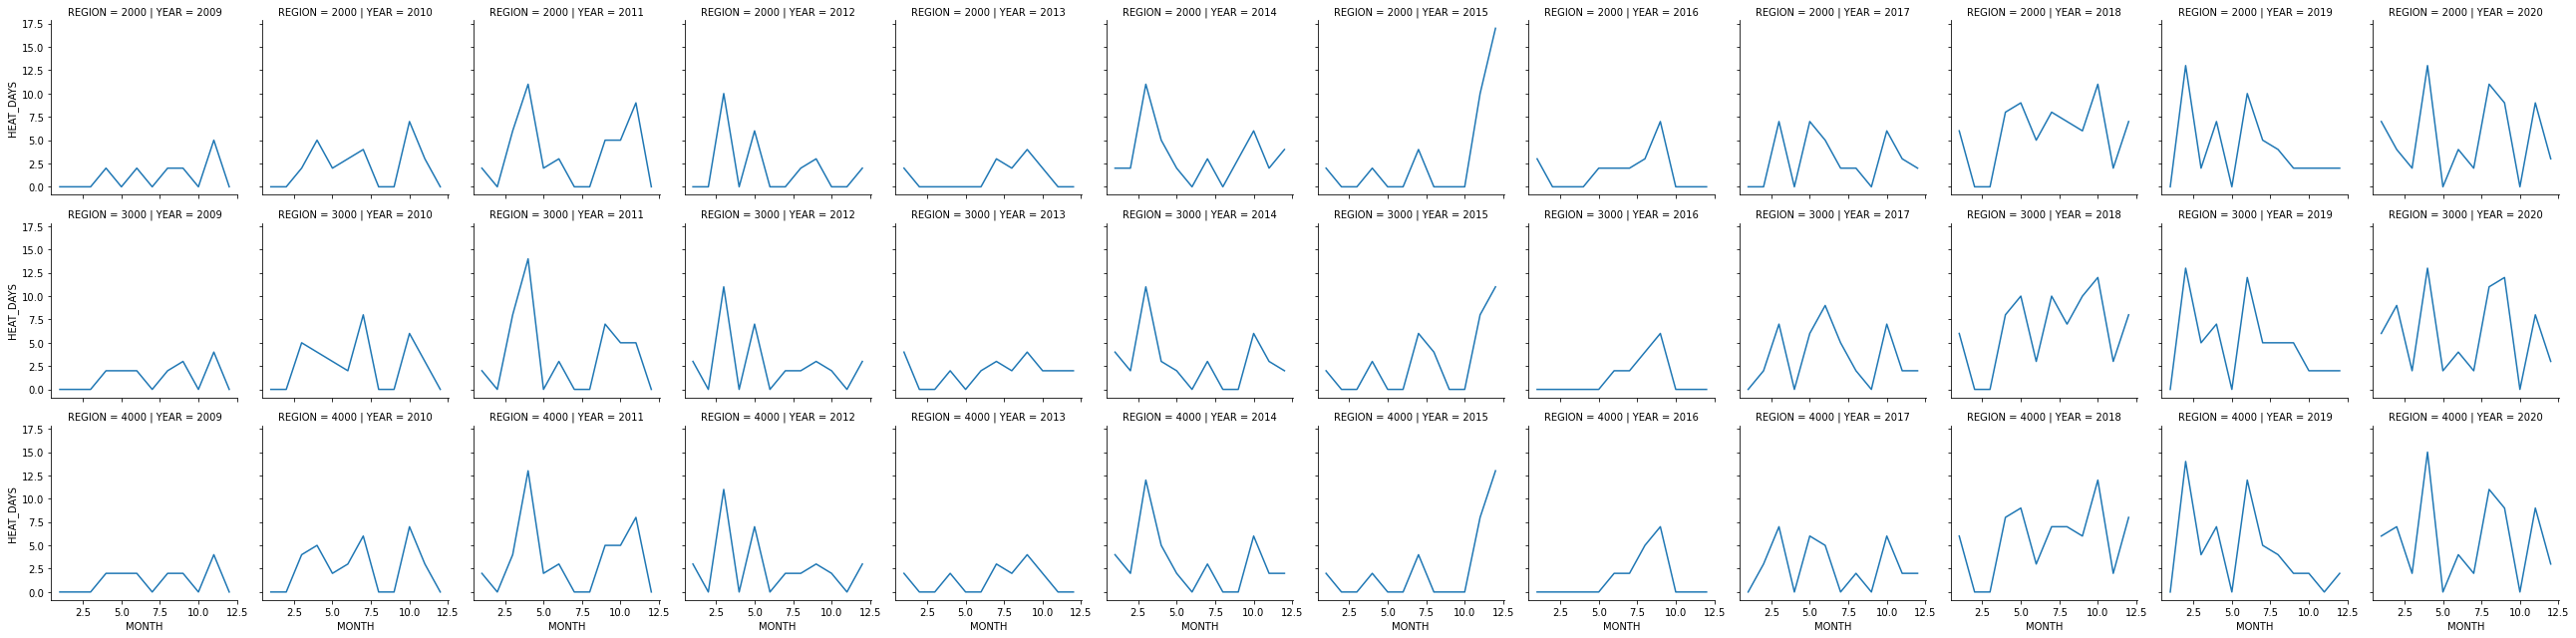

In [7]:
# Line plot for sanity check
gridplot = sns.FacetGrid(climate, col = 'YEAR',  row = 'REGION')
gridplot.map(sns.lineplot, 'MONTH', 'HEAT_DAYS')

In [8]:
# Sample around to see if the data makes sense
climate.sample(5)

,REGION,YEAR,MONTH,TEMP_MEAN,TEMP_VAR,TEMP_RNG,WS50M_MEAN,PRECTOT_MEAN,RH2M_MEAN,HEAT_DAYS
376,4000,2016,5,18.393871,3.340712,15.08,5.663871,3.346452,77.470323,0.0
24,2000,2011,1,5.010000,3.201842,7.19,7.373548,2.526129,94.942903,2.0
140,2000,2020,9,22.184667,3.880432,17.09,6.132000,2.502333,71.273000,9.0
36,2000,2012,1,7.007419,3.084509,7.57,8.636774,2.548387,91.060968,0.0
37,2000,2012,2,3.583793,5.752935,9.58,6.770000,0.945862,87.817931,0.0


In [9]:
# Merge with the mortality dataset
on_key = ['REGION', 'YEAR', 'MONTH']
mortality_merged = mortality.merge(climate, how = 'left', on = on_key)

In [10]:
# Take a look of final output
mortality_merged.sample(5)

,REGION,MONTH,YEAR,AGE-GROUP,SEX,COD,COUNT,TEMP_MEAN,TEMP_VAR,TEMP_RNG,WS50M_MEAN,PRECTOT_MEAN,RH2M_MEAN,HEAT_DAYS
26110,3000,9,2016,65-74,F,"Endocrine, nutritional and metabolic diseases",1,21.465000,2.781117,13.69,5.027000,0.766333,79.346000,6.0
16148,3000,1,2015,75-84,F,Diseases of the nervous system,45,3.835161,2.835693,10.76,8.077097,3.407419,94.821613,2.0
16648,3000,2,2010,0-24,M,Diseases of the digestive system,1,3.047143,3.843884,9.41,7.609286,3.210714,92.451429,0.0
36874,4000,8,2011,85+,M,Diseases of the blood and blood-forming organs...,2,21.653226,2.799706,14.24,5.746129,3.280000,79.284194,0.0
36786,4000,8,2011,0-24,M,"Symptoms, signs and abnormal clinical and labo...",1,21.653226,2.799706,14.24,5.746129,3.280000,79.284194,0.0


In [12]:
mortality_merged.to_csv('mortality_merged.csv', index = False)